# **1. HOG-SVM (Histogram of Oriented Gradients with Support Vector Machine)**

In [ ]:
!pip install roboflow opencv-python-headless scikit-learn

In [ ]:
#Import modules and libraries
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure

In [ ]:
# Initialize Roboflow
rf = Roboflow(api_key="doOkD7FPvdMkVz7FqWND")
project = rf.workspace("instituto-superior-de-engenharia-de-coimbra-flasa").project("objetos-de-aula")
version = project.version(2)
dataset = version.download("yolov5")

# Directories to access Dataset from Roboflow
train_image_dir = os.path.join(dataset.location, "train", "images")
train_annotation_dir = os.path.join(dataset.location, "train", "labels")
test_image_dir = os.path.join(dataset.location, "valid", "images")
test_annotation_dir = os.path.join(dataset.location, "valid", "labels")
edge_case_image_dir = '/content/Objetos-de-aula--2/test/images'

# DATA PREPARATION
# Parse YOLO annotations for the "chair" class
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])  # Class ID 0 is for "chair"
            if class_id == 0:  # Only process for the "chair" class
                x_center, y_center, width, height = map(float, parts[1:])
                # Convert normalized coordinates to pixel values
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                x_max = int((x_center + width / 2) * img_width)
                y_max = int((y_center + height / 2) * img_height)
                bboxes.append((x_min, y_min, x_max, y_max))
    return bboxes

# Prepare dataset function with limit
def prepare_dataset(image_dir, annotation_dir, limit=None):
    images = []
    labels = []
    count = 0

    for annotation_path in glob.glob(os.path.join(annotation_dir, "*.txt")):
        if limit is not None and count >= limit:
            break

        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Resizing images and normalizing pixel values
        for (x_min, y_min, x_max, y_max) in bboxes:
            cropped_img = image[y_min:y_max, x_min:x_max]
            resized_img = cv2.resize(cropped_img, (64, 128))
            normalized_img = resized_img.astype(np.float32) / 255.0  # Normalizing pixel values
            images.append(normalized_img)
            labels.append(1)  # Label for the positive class (chair)

        # Negative sample
        neg_sample = cv2.resize(image[0:128, 0:64], (64, 128))
        normalized_neg_sample = neg_sample.astype(np.float32) / 255.0  # Normalizing pixel values
        images.append(normalized_neg_sample)
        labels.append(0)  # Label for the negative class (no chair)

        count += 1

    return images, labels

# Load training and testing datasets
train_images, train_labels = prepare_dataset(train_image_dir, train_annotation_dir)
test_images, test_labels = prepare_dataset(test_image_dir, test_annotation_dir, limit=5)

# Split the training dataset into training and validation datasets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Extract HOG features
hog = cv2.HOGDescriptor()

def extract_hog_features(images):
    images_uint8 = [(image * 255).astype(np.uint8) for image in images]
    return [hog.compute(image).flatten() for image in images_uint8]

train_features = extract_hog_features(train_images)
val_features = extract_hog_features(val_images)
test_features = extract_hog_features(test_images)

# Model Building Using HOG-SVM

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000]
}

grid = GridSearchCV(LinearSVC(), param_grid, cv=5)
start_time = time.time()
grid.fit(train_features, train_labels)
training_time = time.time() - start_time
print("Best parameters found: ", grid.best_params_)
print("HOG-SVM model trained successfully in {:.2f} seconds.".format(training_time))

# Model evaluation on validation set
val_preds = grid.predict(val_features)

# Calculate performance metrics
val_accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)

print("Validation Accuracy:", val_accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Model evaluation on test set
test_preds = grid.predict(test_features)

# Calculate performance metrics for the test set
test_accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Speed Evaluation
start_time = time.time()
_ = grid.predict(test_features)  # Just for timing
detection_time = time.time() - start_time
print("Detection time for test set:", detection_time)

loading Roboflow workspace...
loading Roboflow project...
Best parameters found:  {'C': 0.1, 'max_iter': 1000}
HOG-SVM model trained successfully in 13.34 seconds.
Validation Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Testing Accuracy: 0.875
Precision: 1.0
Recall: 0.6666666666666666
Detection time for test set: 0.0006127357482910156


**TESTING**

Bounding Boxes: [(77, 92, 483, 639)]


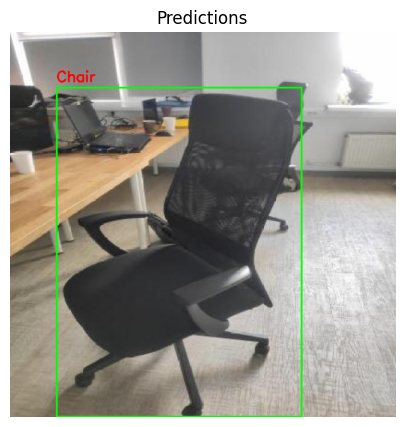

Bounding Boxes: [(121, 262, 384, 600)]


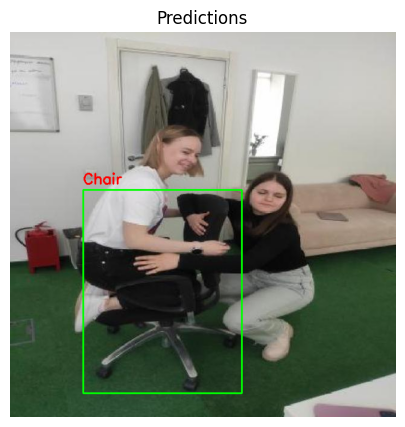

Bounding Boxes: [(128, 78, 477, 613)]


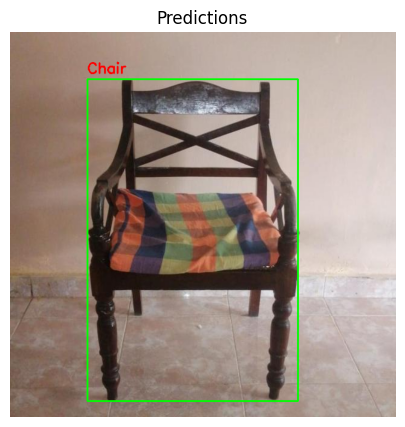

Bounding Boxes: [(160, 62, 478, 601)]


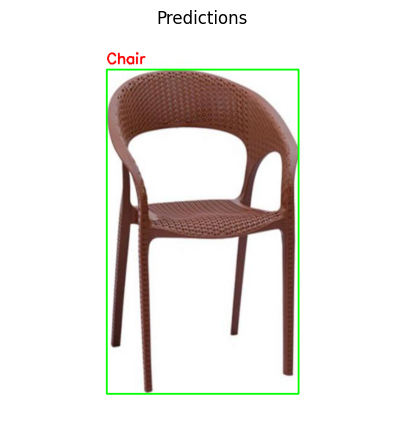

Bounding Boxes: [(251, 192, 413, 443)]


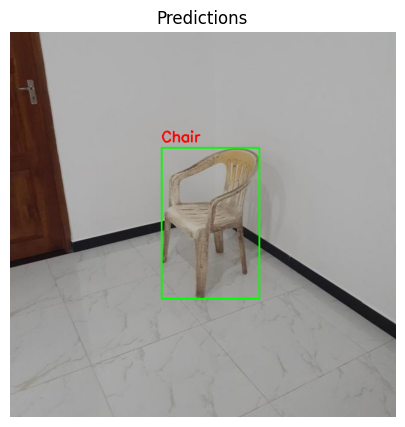

Bounding Boxes: [(321, 146, 603, 472)]


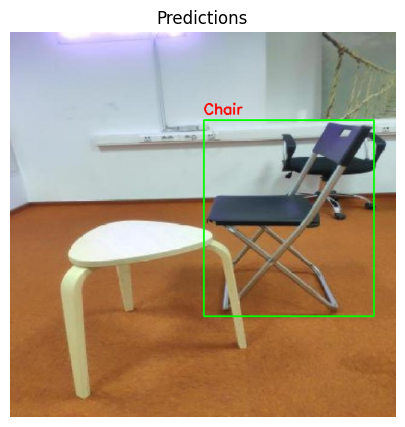

Bounding Boxes: [(278, 181, 445, 415)]


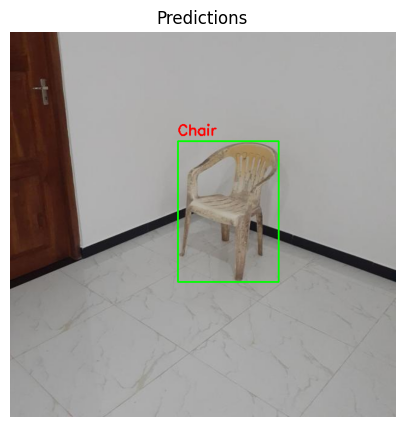

Bounding Boxes: [(74, 124, 454, 564)]


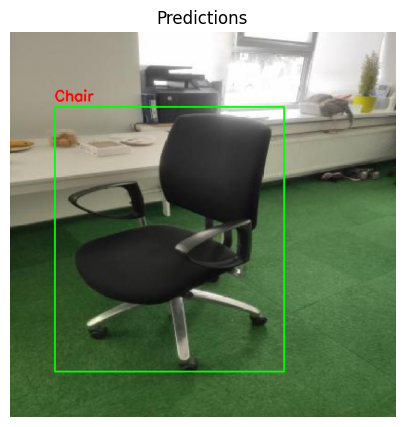

Bounding Boxes: [(121, 40, 521, 627)]


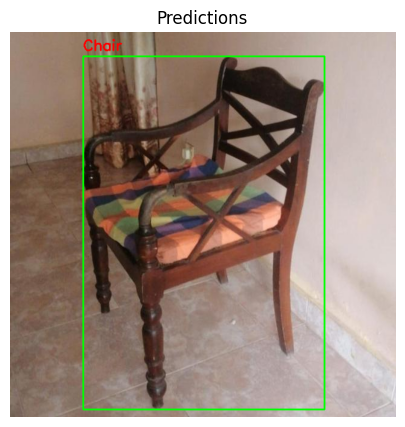

Bounding Boxes: [(151, 200, 574, 601)]


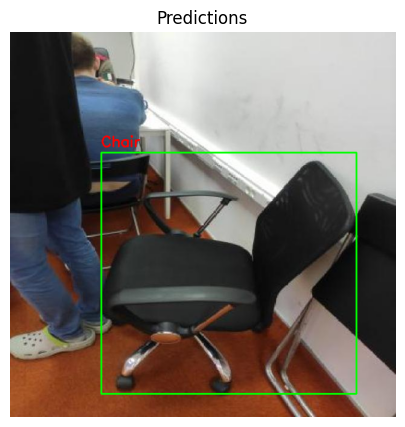

In [ ]:
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:  # Ensure there are enough parts
                # YOLO format: class_id x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, parts)
                x_center, y_center, width, height = (
                    x_center * img_width,
                    y_center * img_height,
                    width * img_width,
                    height * img_height
                )
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                bboxes.append((x_min, y_min, x_max, y_max))
    return bboxes

def visualize_predictions(image_dir, annotations_dir, predictions, limit=10):
    count = 0
    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Debug: Print bounding boxes
        print(f'Bounding Boxes: {bboxes}')

        # Draw the actual bounding boxes on the original image
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            # Add label above the bounding box with a different color
            cv2.putText(image, 'Chair', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Draw predicted bounding boxes (if any prediction exists)
        if count < len(predictions):
            pred = predictions[count]
            if pred == 1:
                for bbox in bboxes:
                    x_min, y_min, x_max, y_max = bbox
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                    cv2.putText(image, 'Chair', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Display the original image with bounding boxes
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Predictions')
        plt.show()

        count += 1
        if count >= limit:
            break

# Example usage (adjust with your actual directories)
visualize_predictions(test_image_dir, test_annotation_dir, test_preds, limit=10)

# Visualize edge case images with the modified approach
edge_case_images, _ = prepare_dataset(edge_case_image_dir, edge_case_image_dir, limit=10)

# Extract HOG features for edge case images
edge_case_features = extract_hog_features(edge_case_images)

for edge_case_image, edge_case_feature in zip(edge_case_images, edge_case_features):
    edge_case_pred_label = grid.predict([edge_case_feature])
    plt.imshow(edge_case_image, cmap='gray')
    plt.title(f'Prediction: {"Chair" if edge_case_pred_label[0] == 1 else "No Chair"}')
    plt.axis('off')
    plt.show()